<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Exercise_Decision_Tree_Titanic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise: Decision Tree**

🎯 **Learning Objectives**
* Predict whether Titanic passengers survived or not based on personal information
* Apply Logistic Regression as a binary classification method
* Evaluate models using classification metrics
* Interprete the models

## **Exercise: Decision Tree**

**Use the 'titanic' dataset from the seaborn dataset**

- Features: 'pclass', 'sex', 'age', 'fare'
- Target: 'survived'

- Drop missing values ​​in the features used, if any.
- Split the data with an 80:20 ratio and random_state = 42.

**Decision Tree**
- Create three models, each using the following hyperparameters:

  - a. maximum depth (max_depth) with a range of 1-30
  - b. minimum samples split (min_samples_split) with a range of 2-150
  - c. minimum samples leaf (min_samples_leaf) with a range of 1-150

- Explain the actions of these hyperparameters and their interpretation.
- Show the plot_tree and interpretation of the best Decision Tree model.

**Initial setup**

In [45]:
# Importing required libraries

# data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# statistics
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# encoding
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import RobustScaler

# imputer
from sklearn.impute import KNNImputer

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [2]:
# setup
plt.style.use("ggplot")


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading dataset
data = sns.load_dataset('titanic')
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### **Data Understanding**

- The dataset describes 891 individuals.
- Each row represents information/characteristics of an individual, such as age, gender, class, and other information, along with survival information.

In [4]:
data = sns.load_dataset('titanic')[['pclass', 'sex', 'age', 'fare', 'survived']]

print(f'Total rows and columns: {data.shape}')
data.head()

Total rows and columns: (891, 5)


,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
| pclass | Integer | Passenger Class |
| age | Integer | Age |
| sex | Text | Gender |
| fare | Float | Cost |
| survived | Text | Income Category |

**Initial Assesment**

In [5]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,pclass,int64,0.00000,False,3,"[3, 1, 2]"
1,sex,object,0.00000,False,2,"[male, female]"
2,age,float64,19.86532,False,88,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,..."
3,fare,float64,0.00000,False,248,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51...."
4,survived,int64,0.00000,False,2,"[0, 1]"


**Descriptive Statistics**

In [6]:
display(data.describe(), data.describe(include='object'))

,pclass,age,fare,survived
count,891.000000,714.000000,891.000000,891.000000
mean,2.308642,29.699118,32.204208,0.383838
std,0.836071,14.526497,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000
25%,2.000000,20.125000,7.910400,0.000000
50%,3.000000,28.000000,14.454200,0.000000
75%,3.000000,38.000000,31.000000,1.000000
max,3.000000,80.000000,512.329200,1.000000


,sex
count,891
unique,2
top,male
freq,577


**Insight**

- The dataset consists of 891 rows and 5 columns.
- Numeric variables: pclass, age, fare
- Categorical variables: sex, survived
- Age has a range of 0.42 - 80
- Fare has a range of 0 - 512.33

### **Exploratory Data Analysis (EDA)**

#### `Numerical Features`

**Data Distribution**

In [7]:
numerical = [var for var in data.drop(columns=['survived']).columns if data[var].dtypes != 'object']

In [8]:
# Normality test
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())

    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"

    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,pclass,1437.109000,0.000000e+00,Not Normally Distributed
1,age,18.105033,1.170960e-04,Not Normally Distributed
2,fare,904.587271,3.727091e-197,Not Normally Distributed


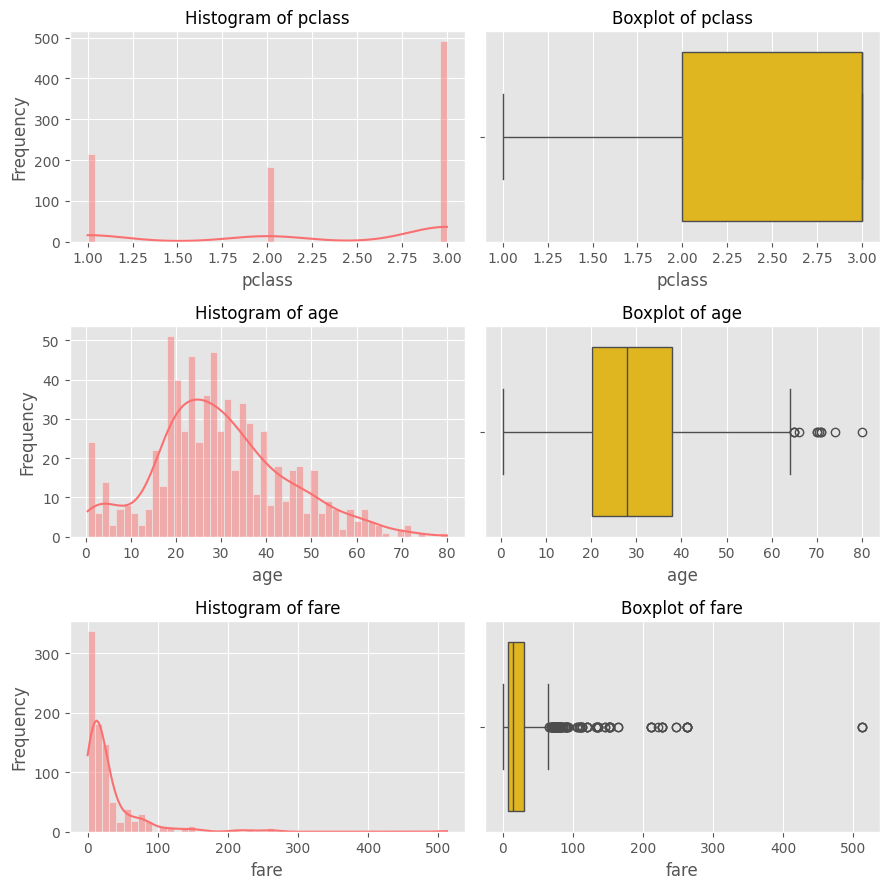

In [9]:
# Numerical distribution
plt.figure(figsize=(9, 9))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

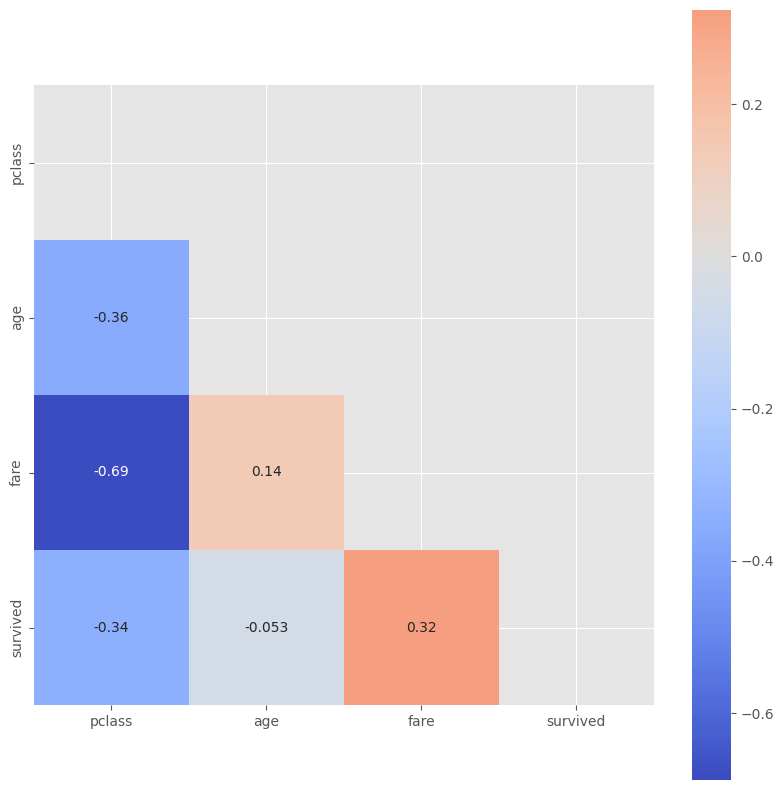

In [10]:
plt.figure(figsize=(10,10))

matrix = np.triu(data.select_dtypes(['int','float' ]).corr(method='spearman'))

sns.heatmap(data=data.select_dtypes(['int','float' ]).corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

**Feature vs Target**

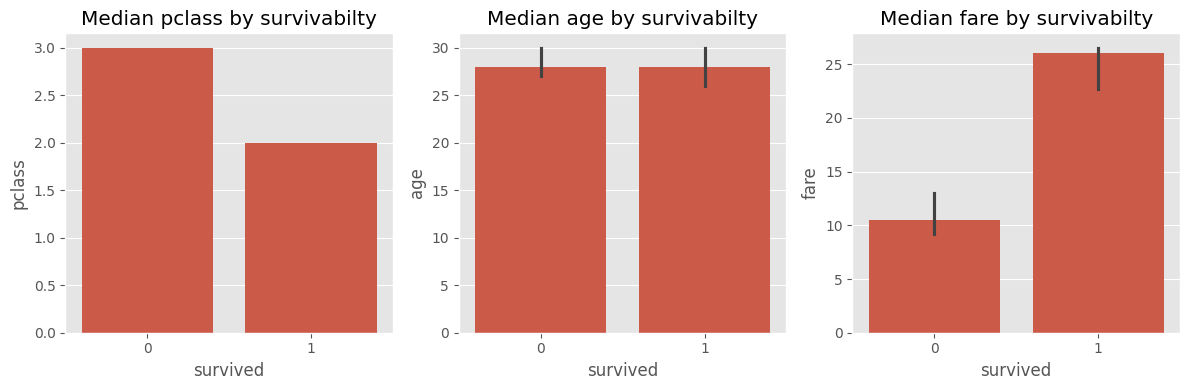

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for col, j in zip(numerical, axes.flatten()):
    ax = sns.barplot(data=data, y= col, x='survived', estimator=np.median, ax= j)
    ax.set_title(f'Median {col} by survivabilty')

plt.tight_layout()
plt.show()

#### `Categorical Features`

**Distribution**

In [12]:
categorical = [var for var in data.columns if data[var].dtypes == 'object']

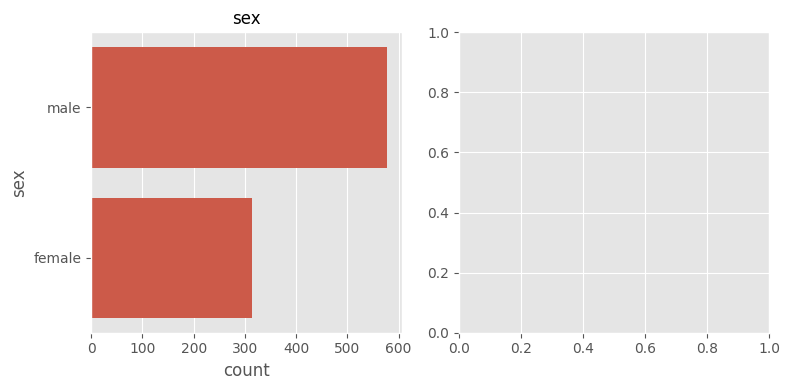

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, j in zip(categorical, axes.flatten()):
    ax = sns.countplot(data=data, y= i, ax= j, order=data[i].value_counts().index)
    ax.set_title(f'{i}', size = 12)

plt.tight_layout()
plt.show()

**Feature vs Target**

In [14]:
def create_plot(data, col):

    agg_table = data.groupby([col, 'survived']).size().unstack().reset_index()
    agg_table['total'] = agg_table[1]+agg_table[0]
    agg_table['% survived'] = (agg_table[1]/agg_table['total']*100).round(2)
    agg_table = agg_table.sort_values(by='% survived', ascending=False)
    agg_table

    fig, axes = plt.subplots(1, 2, figsize=(16,4))

    ax1 = sns.barplot(data=agg_table, y=col, x='% survived', ax=axes[0])
    label = ['{:.1f} %'.format(x) for x in ax1.containers[0].datavalues]
    ax1.bar_label(ax1.containers[0], labels=label, padding=3, label_type='center')
    ax1.set_title(f'Percentage of survived passengers by {col}')

    ax2 = sns.countplot(data=data, y=col, hue='survived', order=agg_table[col], ax=axes[1])
    ax2.set_title(f'Number of passengers by {col} and survived')
    for container in ax2.containers:
        ax2.bar_label(container)
    ax2.set_xlim(0,25000)

    plt.tight_layout()
    plt.show()

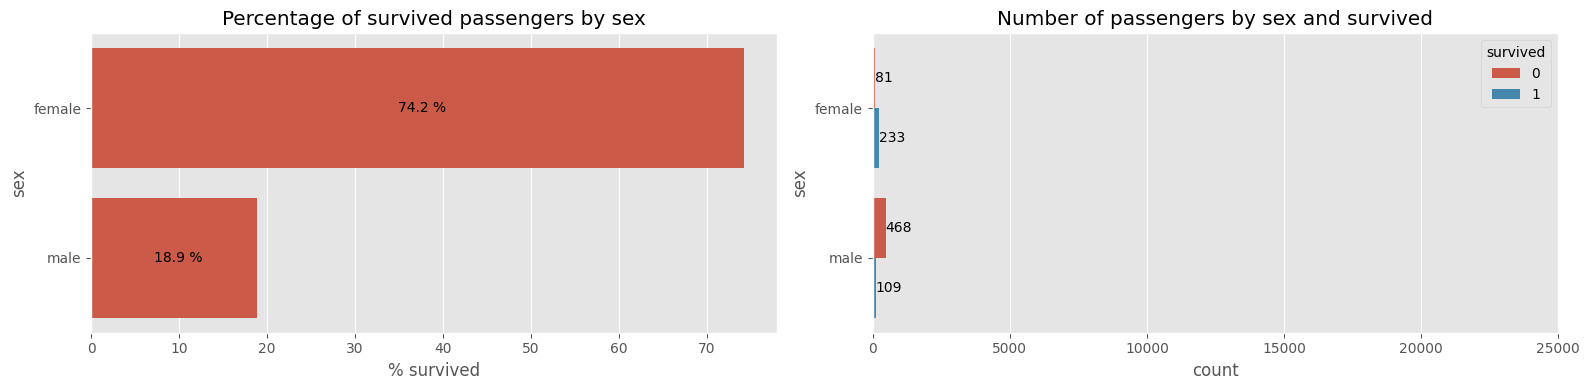

In [15]:
create_plot(data, 'sex')

### **Data Preprocessing**

#### `Duplicates`

In [16]:
print(f"Total number of duplicated data: {data[data.duplicated()].shape}")
print(f'Percentage of duplicated data: {len(data[data.duplicated()])/len(data)*100:.2f}%')

Total number of duplicated data: (123, 5)
Percentage of duplicated data: 13.80%


Handling data duplication:

In [17]:
data.drop_duplicates(keep='last', inplace=True, ignore_index=True)

#### `Missing Values`

In [18]:
pd.DataFrame({'missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,missing values
pclass,0
sex,0
age,98
fare,0
survived,0


There is a missing value in the age column.

#### `Imbalance Data`

In [19]:
# Check the class distribution
from collections import Counter

print("Class distribution:", Counter(data['survived']))

Class distribution: Counter({0: 449, 1: 319})


In [20]:
data['survived'].value_counts(normalize=True)

,proportion
survived,
0,0.584635
1,0.415365


The data can still be categorized as balanced.

#### `Outliers`

In [21]:
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.drop(columns='survived').columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,pclass,0,0.00,-2.0000,6.0000
1,age,7,0.91,-8.5000,67.5000
2,fare,97,12.63,-31.4375,73.8625


There are outliers in the numerical column with percentages ranging from 0% to 12.63%. We will examine the proportion of targets in these outlier data.

In [22]:
proportion = []
indeces = []

for i, row in outlier_df.iterrows():
    outlier = data[(data[row['Column']] < row['Lower Bound']) | (data[row['Column']] > row['Upper Bound'])]
    percentages = (outlier['survived'].value_counts(normalize=True)*100).values
    proportion.append(percentages)
    indeces.append(row['Column'])

pd.DataFrame(proportion, columns=['Not Survived', 'Survived'], index=indeces)

,Not Survived,Survived
pclass,NaN,NaN
age,85.714286,14.285714
fare,76.288660,23.711340


We find that the outliers in the 'age' and 'fare' columns have different proportions of 'Not Survived' and 'Survived' in the 'survived' column compared to the rest of the data. Therefore, we won't remove these outliers because they contain information that impacts the target.

#### `Collinearity`

In [23]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [24]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [25]:
vif_df

,Feature,VIF
1,age,3.149613
0,pclass,2.581941
2,fare,1.410650


In [26]:
dropped_columns

[]

There is no multicollinearity

#### `Cardinality`

In [27]:
categorical = [var for var in data.columns if data[var].dtypes == 'object']

In [28]:
# creating a function to check cardinality
def check_cardinality(data):
    for feature in categorical:
        cardinality = len(data[feature].unique())
        print(f"Cardinality of {feature}: {cardinality}")

        if cardinality > 10:
            print(f"Warning: High cardinality in {feature}.")

check_cardinality(data)

Cardinality of sex: 2


#### `Feature Engineering`

**Encoding**

Now let's encode our categorical features.

We'll Convert the `sex` feature/column using One Hot Encoding, as this feature is non-ordinal and contains only a small number of unique data points.

### **Modeling**

**Define Features (X) and Target (y)**

In [29]:
# feature
X = data.drop(columns='survived')

# target
y = data['survived']

**Data Splitting**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020, stratify=y
)

**Pipeline**

| Technique | Action |
| ----------------------------- | ----------- |
| KNN Imputer | Filling missing values ​​in the `age` column based on the `fare` and `pclass` features |
| One Hot Encoding | Transforming the `sex` column with unique values ​​<= 10 |

In [31]:
# Encoding and Imputer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['sex']),
    ('knn_imputer', KNNImputer(n_neighbors=5, weights='uniform'), ['age', 'pclass', 'fare']),
], remainder='passthrough')

In [32]:
# .fit
transformer.fit(X_train)

# .transform method
X_train_prep = transformer.transform(X_train)
X_test_prep = transformer.transform(X_test)

`Get Col Names`

In [33]:
col_names = list(transformer.transformers_[0][1].get_feature_names_out()) + \
    list(transformer.transformers_[1][2])

col_names

['sex_male', 'age', 'pclass', 'fare']

In [34]:
X_train_prep = pd.DataFrame(data=X_train_prep, columns=col_names)
X_train_prep.head()

,sex_male,age,pclass,fare
0,1.0,1.0,3.0,39.6875
1,1.0,2.0,3.0,29.1250
2,1.0,56.0,1.0,30.6958
3,1.0,30.0,2.0,10.5000
4,1.0,26.0,3.0,8.0500


In [35]:
X_test_prep = pd.DataFrame(data=X_test_prep, columns=col_names)
X_test_prep.head()

,sex_male,age,pclass,fare
0,1.0,20.0,3.0,9.8458
1,1.0,25.0,3.0,7.7750
2,0.0,37.6,1.0,133.6500
3,0.0,27.4,3.0,23.2500
4,1.0,29.0,3.0,7.7750


### `Model Experiment`

**Benchmark Model**

In [36]:
from sklearn.metrics import accuracy_score

# Define the model
estimator = DecisionTreeClassifier(max_depth=2, random_state=42)

# Fitting the model
estimator.fit(X_train_prep, y_train)

# Predict
ypred_test = estimator.predict(X_test_prep)

# Evaluate
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the test set: 0.7922077922077922


**Model Selection**

`Max Depth`

- Set maximum depth (max_depth) with a range of 1-30

In [37]:
# Declare a list to hold the result
training_accuracies = []
testing_accuracies = []
abs_differences = []

# Specify the number of k iterations
depth = range(1, 30, 1)
best_accuracy = 0

for i in depth:
    # Train the model
    estimator = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=42)
    estimator.fit(X_train_prep, y_train)

    # Predict on the training and testing data
    y_train_pred = estimator.predict(X_train_prep)
    y_test_pred = estimator.predict(X_test_prep)

    # Calculate the accuracies score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Append them to the lists
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    abs_differences.append(np.abs(training_accuracy - testing_accuracy))

    # Select depth with the highest test accuracy score
    if best_accuracy < testing_accuracies[-1]:
        best_accuracy = testing_accuracies[-1]
        best_depth = i

# Compile the results into a dataframe
pd.DataFrame(
    {
        'Max depth': [i for i in depth],
        'Training': training_accuracies,
        'Testing': testing_accuracies,
        'Difference': abs_differences
    }
).sort_values(by=['Difference', 'Testing', 'Training'], ascending=[True, False, False]).head()


,Max depth,Training,Testing,Difference
4,5,0.827362,0.831169,0.003807
1,2,0.770358,0.792208,0.021849
3,4,0.796417,0.772727,0.023690
5,6,0.835505,0.805195,0.030310
0,1,0.755700,0.798701,0.043001


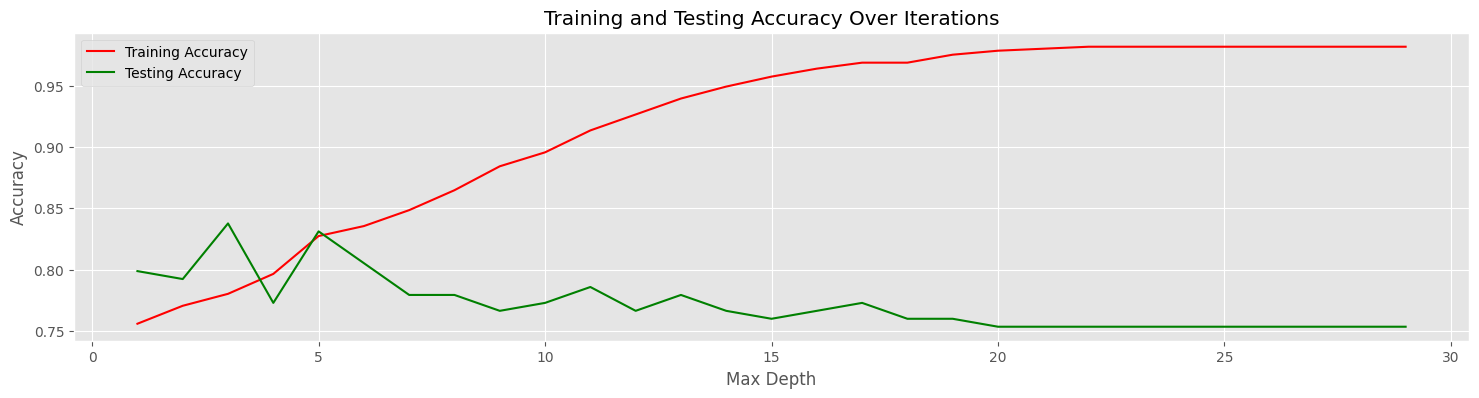

In [38]:
import matplotlib.pyplot as plt

# Plot the training and testing accuracies
plt.figure(figsize=(18,4))
plt.plot(depth, training_accuracies, label="Training Accuracy", c='red')
plt.plot(depth, testing_accuracies, label="Testing Accuracy", c='green')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy Over Iterations")
plt.legend()
plt.show()

**Insight**

- A max_depth of 1-2 indicates underfitting, as the accuracy on both the train and test sets is not very good. The Decision Tree model will underfit at a small depth.
- A max_depth > 6 indicates overfitting, as the accuracy on the train set is much better than the accuracy on the test set.
- The best max_depth is 5, as the accuracy on the train and test sets is quite good and not significantly different. This indicates that the model is stable. The accuracy on the test set is 83.11%.

`Minimum Sample Split`
* Set minimum samples split (min_samples_split) with a range of 2-150

In [39]:
# Declare a list to hold the result
training_accuracies = []
testing_accuracies = []
abs_differences = []

# Specify the number of k iterations
min_split = range(2, 150, 1)
best_accuracy = 0

for i in min_split:
    # Train the model
    estimator = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, random_state=42)
    estimator.fit(X_train_prep, y_train)

    # Predict on the training and testing data
    y_train_pred = estimator.predict(X_train_prep)
    y_test_pred = estimator.predict(X_test_prep)

    # Calculate the accuracies score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Append them to the lists
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    abs_differences.append(np.abs(training_accuracy - testing_accuracy))

    # Select split with the highest test accuracy score
    if best_accuracy < testing_accuracies[-1]:
        best_accuracy = testing_accuracies[-1]
        best_depth = i

# Compile the results into a dataframe
pd.DataFrame(
    {
        'Min sample split': [i for i in min_split],
        'Training': training_accuracies,
        'Testing': testing_accuracies,
        'Difference': abs_differences
    }
).sort_values(by=['Difference', 'Testing', 'Training'], ascending=[True, False, False]).head()


,Min sample split,Training,Testing,Difference
75,77,0.783388,0.792208,0.00882
76,78,0.783388,0.792208,0.00882
77,79,0.783388,0.792208,0.00882
78,80,0.783388,0.792208,0.00882
79,81,0.783388,0.792208,0.00882


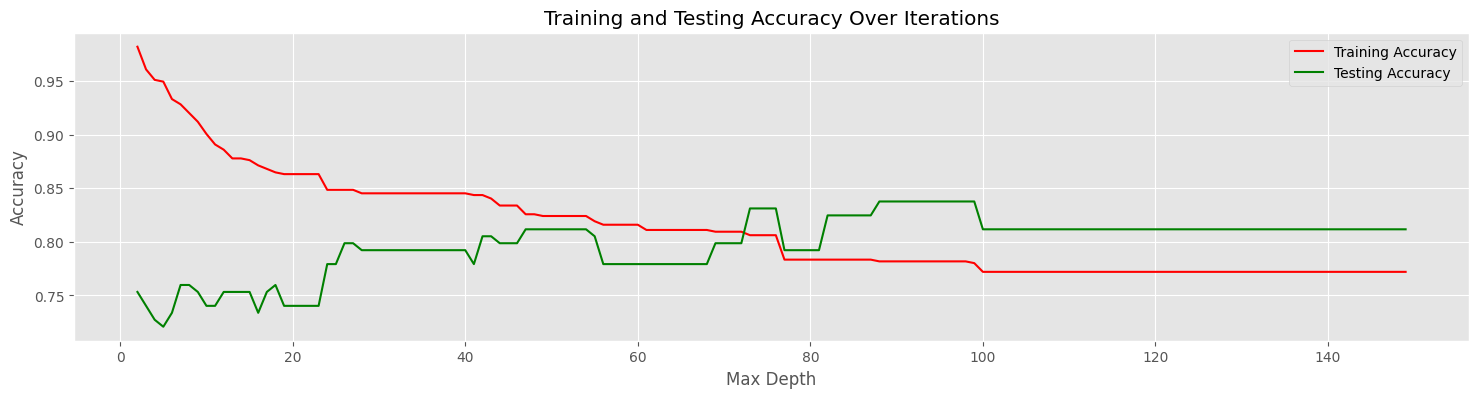

In [40]:
import matplotlib.pyplot as plt

# Plot the training and testing accuracies
plt.figure(figsize=(18,4))
plt.plot(min_split, training_accuracies, label="Training Accuracy", c='red')
plt.plot(min_split, testing_accuracies, label="Testing Accuracy", c='green')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy Over Iterations")
plt.legend()
plt.show()

**Insight**

- The minimum sample split is the minimum number of samples required to create a new split on an internal node.
- For example, if min_samples_split = 5, and there are 7 samples on the internal node, then the split can be performed.
- A minimum sample split of 1-40 indicates overfitting, with a significant difference in accuracy between the train set and the test set.
- A minimum sample split of >= 80 indicates underfitting, as the training accuracy is significantly worse than the testing accuracy.
- The best minimum sample split is from 77 to 81 , as the training accuracy is not significantly different from the testing accuracy. This indicates that the model is stable. The accuracy on the test set is 79.22%.

`Minimum Sample Leaf`
* Set minimum samples leaf (min_samples_leaf) with a range of 1-150

In [41]:
# Declare a list to hold the result
training_accuracies = []
testing_accuracies = []
abs_differences = []

# Specify the number of k iterations
min_leaf = range(2, 150, 1)
best_accuracy = 0

for i in min_leaf:
    # Train the model
    estimator = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, random_state=42)
    estimator.fit(X_train_prep, y_train)

    # Predict on the training and testing data
    y_train_pred = estimator.predict(X_train_prep)
    y_test_pred = estimator.predict(X_test_prep)

    # Calculate the accuracies score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Append them to the lists
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    abs_differences.append(np.abs(training_accuracy - testing_accuracy))

    # Select leaf with the highest test accuracy score
    if best_accuracy < testing_accuracies[-1]:
        best_accuracy = testing_accuracies[-1]
        best_depth = i

# Compile the results into a dataframe
pd.DataFrame(
    {
        'Min sample leaf': [i for i in min_leaf],
        'Training': training_accuracies,
        'Testing': testing_accuracies,
        'Difference': abs_differences
    }
).sort_values(by=['Difference', 'Testing', 'Training'], ascending=[True, False, False]).head()

,Min sample leaf,Training,Testing,Difference
8,10,0.833876,0.831169,0.002707
16,18,0.799674,0.805195,0.005521
17,19,0.799674,0.805195,0.005521
18,20,0.799674,0.805195,0.005521
19,21,0.799674,0.805195,0.005521


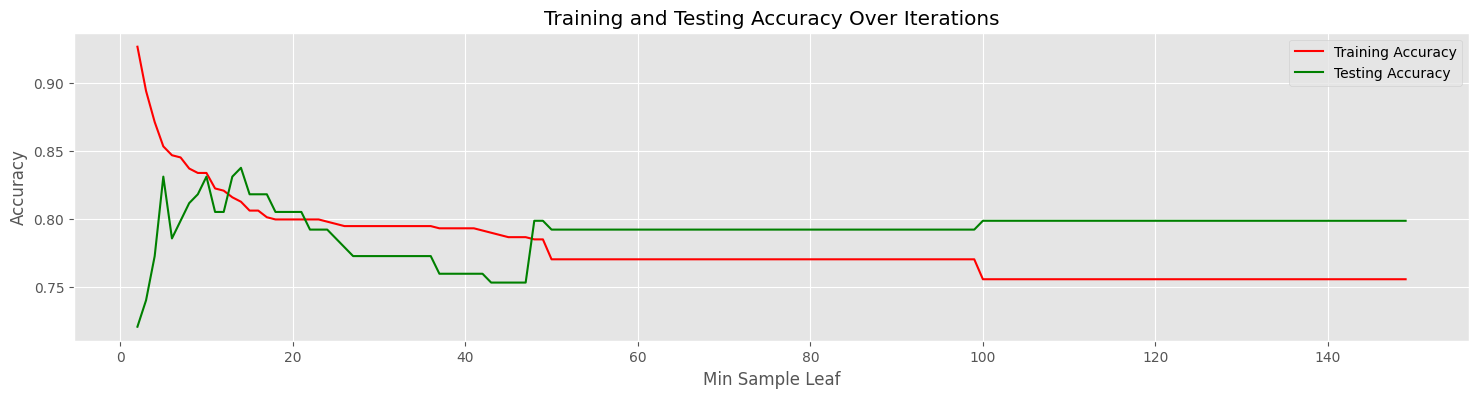

In [42]:
import matplotlib.pyplot as plt

# Plot the training and testing accuracies
plt.figure(figsize=(18,4))
plt.plot(min_leaf, training_accuracies, label="Training Accuracy", c='red')
plt.plot(min_leaf, testing_accuracies, label="Testing Accuracy", c='green')
plt.xlabel("Min Sample Leaf")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy Over Iterations")
plt.legend()
plt.show()

**Insight**

- Minimum sample leaf is the minimum number of samples required to form one leaf.
- For example, if the last split resulted in two leaf nodes, the first with two samples and the second with six samples, if min_samples_leaf = 3, then splitting would not be possible because one of the nodes only has two samples, even though the internal nodes have eight samples overall.
- Minimum sample leaf = 1-5 indicates overfitting, with a significant difference in accuracy between the train set and the test set.
- Minimum sample leaf >= 20 indicates underfitting, as the training accuracy is significantly worse than the testing accuracy.
- Best Minimum sample leaf = 10, as the training accuracy is not significantly different from the testing accuracy. This indicates a stable model. The accuracy on the test set is 83.11%.

| Parameters | Value | Accuracy Score |
| --- | --- | --- |
| max_depth | 5 | 83.11 |
| min_samples_split | 77 | 79.22 |
| min_samples_leaf | 10 | 83.11 |



The best model uses the parameters between max_depth=5 and min_samples_leaf=10

### **Model Evaluation**

Lets finalize the final model, which one is the best models among the tested models

In [52]:
# Model with max_depth = 5
best_estimator_max_depth5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
best_estimator_max_depth5.fit(X_train_prep, y_train)

ypred_train = best_estimator_max_depth5.predict(X_train_prep)
ypred_test = best_estimator_max_depth5.predict(X_test_prep)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.8273615635179153
Model accuracy score in the test set: 0.8311688311688312


In [53]:
# Model with min_samples_leaf = 10
best_estimator_minsamplesleaf10 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, random_state=42)
best_estimator_minsamplesleaf10.fit(X_train_prep, y_train)

ypred_train = best_estimator_minsamplesleaf10.predict(X_train_prep)
ypred_test = best_estimator_minsamplesleaf10.predict(X_test_prep)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.8338762214983714
Model accuracy score in the test set: 0.8311688311688312


In [54]:
# Model with combined both max_depth = 5 and min_samples_leaf = 10
best_estimator_combined = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
best_estimator_combined.fit(X_train_prep, y_train)

ypred_train = best_estimator_combined.predict(X_train_prep)
ypred_test = best_estimator_combined.predict(X_test_prep)

print('Model accuracy score in the training set:', accuracy_score(y_train, ypred_train))
print('Model accuracy score in the test set:', accuracy_score(y_test, ypred_test))

Model accuracy score in the training set: 0.8175895765472313
Model accuracy score in the test set: 0.8181818181818182


**Final model**

Its turn out the best model is the model with min_sample_leaf=10. Although the performance on the test accuracy is same (both scores 83.11) between max_depth=5 and min_samples_leaf=10, the later has better training scores (0.827) which contribute to less difference between training and testing score.

### **Model Interpretation**

- Accuracy on the test set: 83.17%
- The Decision Tree model was able to correctly predict passenger survivability (both survivors and non-survivors) 83.17% of the time.
- Of the 154 passengers, 128 were correctly labeled.

`Plot Tree`

In [51]:
y_train.value_counts()

,count
survived,
0,359
1,255


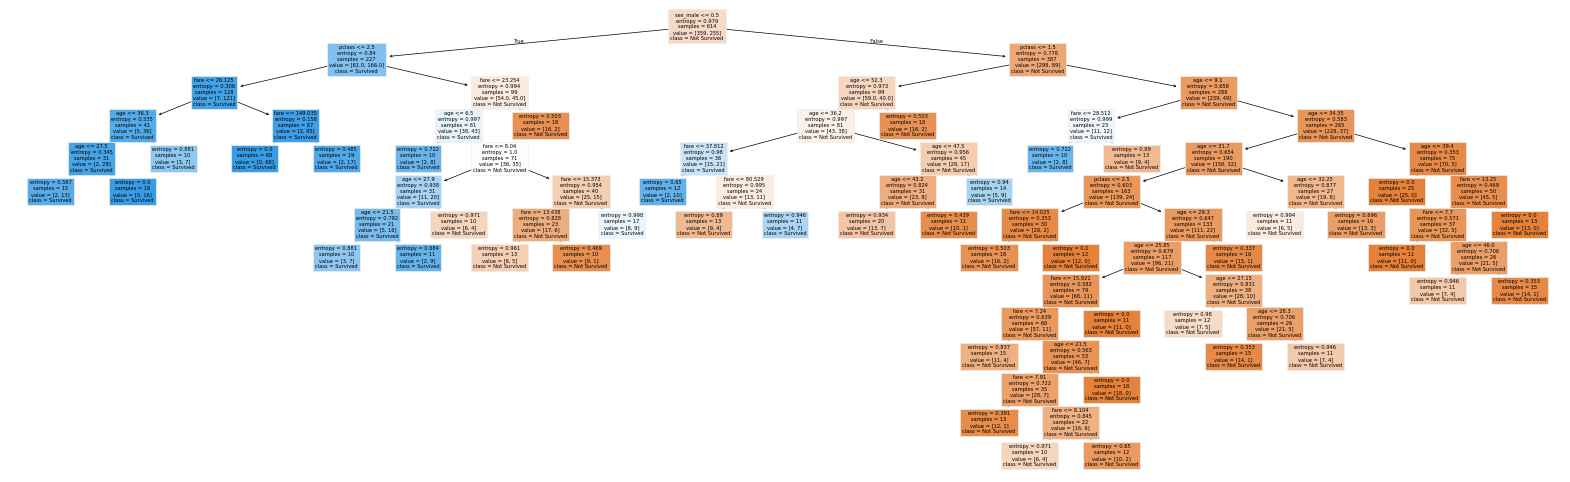

In [55]:
from sklearn.tree import plot_tree

# Visualize the decision tree
fig = plt.figure(figsize=(20,6))
_ = plot_tree(
    decision_tree=best_estimator_minsamplesleaf10,
    feature_names=X_train_prep.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True
)

`Feature Importances`

sex_male: 0.379
age: 0.217
pclass: 0.242
fare: 0.162


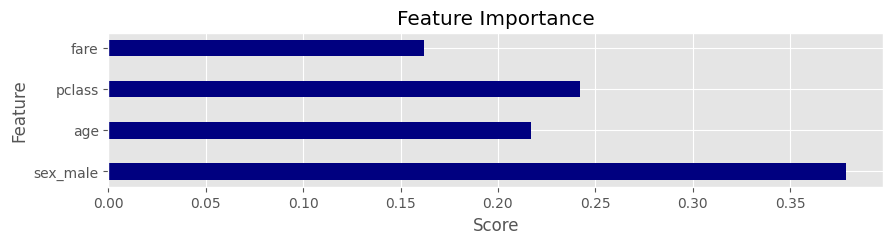

In [56]:
importances = np.round(best_estimator_minsamplesleaf10.feature_importances_, 3)

# Get feature names
feature_names = X_train_prep.columns

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(10,2))

# Plot feature importances
plt.title("Feature Importance")
plt.barh(feature_names, importances, height=0.4, color='navy')
plt.xlabel('Score')
plt.ylabel('Feature')

# Show the plot
plt.show()


**Insight**

Decision trees determine splitters by maximizing information gain (impurity reduction). Calculating the average impurity reduction for each feature over the entire tree yields a feature importance score. Therefore, based on the graph above, the sex_male feature is the most important.

**Predict to New Data**

In [57]:
X_train

,pclass,sex,age,fare
129,3,male,1.0,39.6875
14,3,male,2.0,29.1250
139,1,male,56.0,30.6958
174,2,male,30.0,10.5000
330,3,male,26.0,8.0500
...,...,...,...,...
317,3,male,NaN,7.7292
176,3,male,51.0,8.0500
476,1,female,39.0,55.9000
111,3,female,24.0,15.8500


In [58]:
new_data = pd.DataFrame({
    'pclass' : [1, 1, 1, 3, 3, 1],
    'sex' : ['male', 'male', 'male', 'female', 'female', 'female'],
    'age' : [5, 40, 80, 5, 40, 80],
    'fare': [25, 50, 100, 25, 50, 100]
})

new_data

,pclass,sex,age,fare
0,1,male,5,25
1,1,male,40,50
2,1,male,80,100
3,3,female,5,25
4,3,female,40,50
5,1,female,80,100


In [59]:
# example of predicting new data
best_estimator_minsamplesleaf10.predict(transformer.transform(new_data)).round(2)

array([1, 0, 0, 0, 0, 1])